In [ ]:
from datetime import date, timedelta
import gc
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

In [2]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [ ]:
print("Training and predicting models...")
params = {
    'num_leaves': 80,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 16
}

MAX_ROUNDS = 5000
val_pred = []
test_pred = []
cate_vars = []
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * num_days) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=125, verbose_eval=50
    )
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

weight = items["perishable"] * 0.25 + 1
err = (y_val - np.array(val_pred).transpose())**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err))

y_val = np.array(val_pred).transpose()
df_preds = pd.DataFrame(
    y_val, index=df_2017.index,
    columns=pd.date_range("2017-07-26", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)
df_preds["unit_sales"] = np.clip(np.expm1(df_preds["unit_sales"]), 0, 1000)
df_preds.reset_index().to_csv('lgb_cv.csv', index=False)

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb_sub.csv', float_format='%.4f', index=None)

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame({"x":["a","b"]*20,
                  "y":np.random.random(40),
                  "z":np.random.random(40)})

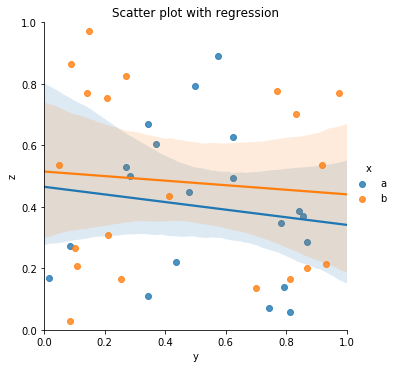

In [13]:
# plot the data using seaborn
sns.lmplot("y", "z", df, hue = "x")
# ----------------------------------------------------------------------------------------------------
# prettify the plot

# since we are using seaborn and this library uses matplotlib behind the scenes
# you can call plt.gca (get current axes) and use all the familiar matplotlib commands
ax = plt.gca()

# change the upper limit of the plot to make it more pleasant
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# set title
ax.set_title("Scatter plot with regression");

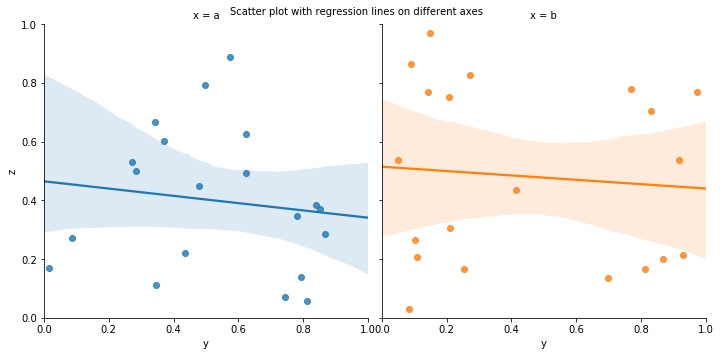

In [14]:
# plot the data using seaborn
axes = sns.lmplot("y", 
                  "z", 
                  df, 
                  hue = "x", 
                  col = "x" # by specifying the col, seaborn creates several axes for each group
                 )
# ----------------------------------------------------------------------------------------------------
# prettify the plot

# change the upper limit of the plot to make it more pleasant
axes.set( xlim = (0, 1), ylim = (0, 1))

# set title for all axes using plt
plt.suptitle("Scatter plot with regression lines on different axes", fontsize = 10);

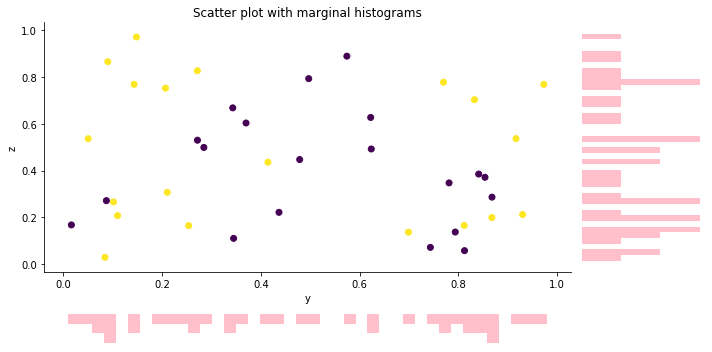

In [18]:
# plot the data
# instanciate the figure
fig = plt.figure(figsize = (10, 5))
# in this case we use gridspec.
# check the basics section of this kernel if you need help.
gs = fig.add_gridspec(5, 5)
ax1 = fig.add_subplot(gs[:4, :-1])
# main axis: scatter plot
# this line is very nice c = df.manufacturer.astype('category').cat.codes
# since it basically generate a color for each category
ax1.scatter(df.y, df.z, c = df.x.astype('category').cat.codes) 

# set the labels for x and y
ax1.set_xlabel("y")
ax1.set_ylabel("z")

# set the title for the main plot
ax1.set_title("Scatter plot with marginal histograms")

# prettify the plot
# get rid of some of the spines to make the plot nicer
ax1.spines["right"].set_color("None")
ax1.spines["top"].set_color("None")

# using familiar slicing, get the bottom axes and plot
ax2 = fig.add_subplot(gs[4:, :-1])
ax2.hist(df.y, 40, orientation = 'vertical', color = "pink")

# invert the axis (it looks up side down)
ax2.invert_yaxis()

# prettify the plot
# set the ticks to null
ax2.set_xticks([])
ax2.set_yticks([])
# no axis to make plot nicer
ax2.axison = False

# using familiar slicing, get the left axes and plot
ax3 = fig.add_subplot(gs[:4, -1])
ax3.hist(df.z, 40, orientation = "horizontal", color = "pink")

# prettify the plot
# set the ticks to null
ax3.set_xticks([])
ax3.set_yticks([])
# no axis to make plot nicer
ax3.axison = False

# make all the figures look nicier
fig.tight_layout()

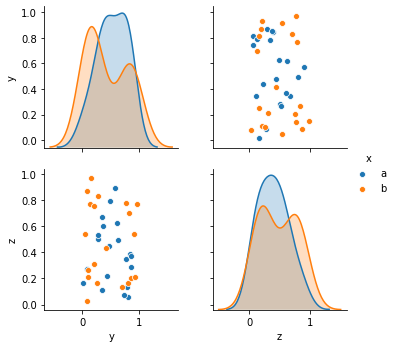

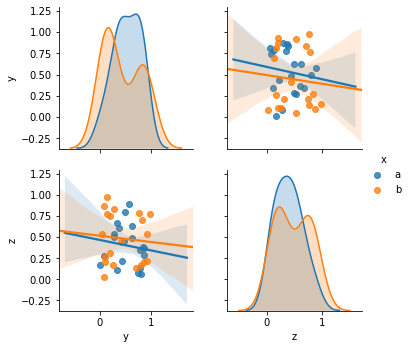

In [21]:
# plot the data using seaborn
sns.pairplot(df, 
             hue = "x" # helps to separate the values by specios
            );
sns.pairplot(df, 
             kind = "reg", # make a regression line for eac hue and each variables
             hue = "x"
            );

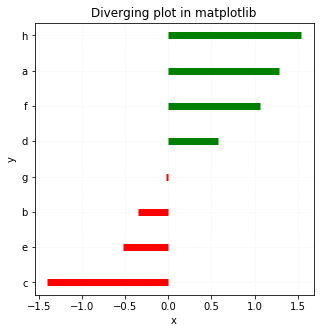

In [33]:
df = pd.DataFrame({"x":["a","b","c","d","e","f","g","h"],
                   "y":np.random.randn(8)})

# sort value and reset the index
df.sort_values("y", inplace = True)
df.reset_index(inplace = True)

# create a color list, where if value is above > 0 it's green otherwise red
colors = ["red" if x < 0.5 else "green" for x in df["y"]]

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()
# plot using horizontal lines and make it look like a column by changing the linewidth
ax.hlines(y = df.index, xmin = 0 , xmax = df["y"],  color = colors, linewidth = 7)

# ----------------------------------------------------------------------------------------------------
# prettify the plot
# set x and y axis
ax.set_xlabel("x")
ax.set_ylabel("y")

# set a title
ax.set_title("Diverging plot in matplotlib")

# make a grid to help separate the lines
ax.grid(linestyle='--', alpha=0.1)

# change the y ticks
# first you set the yticks
ax.set_yticks(df.index)

# then you change them using the car names
# same can be achived using plt.yticks(df.index, df.cars)
ax.set_yticklabels(df.x);

In [ ]:
# instanciate the figure
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# plot the data

# hist returns a tuple of 3 values
# let's unpack it
n, bins, patches = ax.hist(lx, bins = 30, stacked = True, density = False, color = colors)

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# change x lim
ax.set_ylim(0, 25)
# set the xticks to reflect every third value
ax.set_xticks(bins[::3])

# set a title
ax.set_title("Stacked Histogram of displ colored by class")

# add a custom legend wit class and color
# you have to pass a dict
ax.legend({class_:color for class_, color in zip(ln, colors)})

# set the y label
ax.set_ylabel("Frequency");

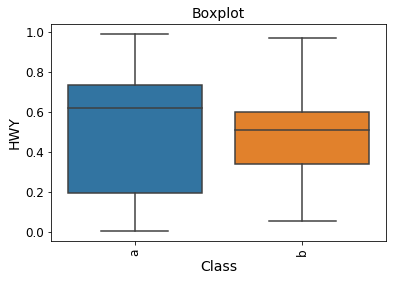

In [37]:
df = pd.DataFrame({"x":["a","b"]*20,
                  "y":np.random.random(40),
                  "z":np.random.random(40)})

ax = sns.boxplot(x = "x", y = "y", data = df)
# prettify the plot

# change the font of the x and y ticks (numbers on the axis)
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# set and x and y label
ax.set_xlabel("Class", fontsize = 14)
ax.set_ylabel("HWY", fontsize = 14)

# set a title
ax.set_title("Boxplot", fontsize = 14);

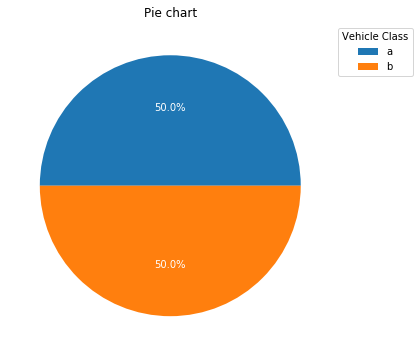

In [40]:
# create a dictionary of classes and their totals
d = df["x"].value_counts().to_dict()

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# plot the data using matplotlib
ax.pie(d.values(), # pass the values from our dictionary
       labels = d.keys(), # pass the labels from our dictonary
       autopct = '%1.1f%%', # specify the format to be plotted
       textprops = {'fontsize': 10, 'color' : "white"} # change the font size and the color of the numbers inside the pie
      )

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# set the title
ax.set_title("Pie chart")

# set the legend and add a title to the legend
ax.legend(loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 10, title = "Vehicle Class");

In [ ]:
# temlplate for time sereis plots
def create_date_tick(df):
    '''
    Converts dates from this format: Timestamp('1949-01-01 00:00:00')
    To this format: 'Jan-1949'
    '''
    df["date"] = pd.to_datetime(df["date"]) # convert to datetime
    df["month_name"] = df["date"].dt.month_name() # extracts month_name
    df["month_name"] = df["month_name"].apply(lambda x: x[:3]) # passes from January to Jan
    df["year"] = df["date"].dt.year # extracts year
    df["new_date"] = df["month_name"].astype(str) + "-" + df["year"].astype(str) # Concatenaes Jan and year --> Jan-1949

# create the time column and the xtickslabels column
create_date_tick(df)

# get the y values (the x is the index of the series)
y = df["value"]

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# plot the data using matplotlib
ax.plot(y, color = "red", alpha = .5, label = "Air traffic")

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# set the gridlines
ax.grid(alpha = .3)

# change the ylim
ax.set_ylim(0, 700)

# get the xticks and the xticks labels
xtick_location = df.index.tolist()[::6]
xtick_labels = df["new_date"].tolist()[::6]

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location)

# chage the label from '1949-01-01 00:00:00' to this 'Jan-1949'
ax.set_xticklabels(xtick_labels, rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})

# change the size of the font of the x and y axis
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# set the title and the legend of the plot
ax.set_title("Air Passsengers Traffic (1949 - 1969)", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10);

In [ ]:
# get the data
PATH = "/kaggle/input/the-50-plot-challenge/mortality.csv"
df = pd.read_csv(PATH)

# set the date column to be the index
df.set_index("date", inplace = True)

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# plot the data using matplotlib
ax.plot(df["mdeaths"], color = "red", alpha = .5, label = "mdeaths")
ax.plot(df["fdeaths"], color = "blue", alpha = .5, label = "fdeaths")

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# get the xticks and the xticks labels
xtick_location = df.index.tolist()[::6]
xtick_labels = df.index.tolist()[::6]

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location)
ax.set_xticklabels(xtick_labels, rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'});

# change the x and y ticks to be smaller
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# add legend, a title and grid to make it look nicer
ax.legend(loc = "upper left", fontsize = 10)
ax.set_title("Mdeaths and fdeaths over time", fontsize = 14)
ax.grid(axis = "y", alpha = .3)

In [ ]:
# multi axis
# Multiple timeseries is a special case when we plot 2 series and see their performance over time
# However, here since the data is on a different scale, we will add a secondary y axis

# More info: 
# https://study.com/academy/lesson/time-series-plots-definition-features.html

# ----------------------------------------------------------------------------------------------------
# get the data
PATH = "/kaggle/input/the-50-plot-challenge/economics.csv"
df = pd.read_csv(PATH)

# set the date column to be the index
df.set_index("date", inplace = True)

# ----------------------------------------------------------------------------------------------------
# prepare the data for plotting
# get the x and y values
x_1 = df["psavert"]
x_2 = df["unemploy"]

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (14, 8))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# plot the data using matplotlib
# here is the main axis
ax.plot(x_1, color = "red", alpha = .3, label = "Personal savings rate")

# suing twinx we can create a secondary axis
ax2 = ax.twinx()
# plot the data on the secondary axis
ax2.plot(x_2, color = "blue", alpha = .3, label = "Unemployment rate")

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# get the xticks and the xticks labels (every 12 entry)
xtick_location = df.index.tolist()[::12]
xtick_labels = df.index.tolist()[::12]

# set the xticks to be every 12'th entry
# every 12 months
ax.set_xticks(xtick_location)
ax.set_xticklabels(xtick_labels, rotation = 90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'});

# change the x and y ticks to be smaller for the main axis and for the secondary axis
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)
ax2.tick_params(axis = 'y', labelsize = 12)

# set a title and a grid
ax.set_title("Personal savings rate vs Unemployed rate: 2 axis", fontsize = 16)
ax.grid(axis = "y", alpha = .3)